In [0]:
!pip install pyLDAvis 

     |████████████████████████████████| 1.6MB 6.0MB/s 
     |████████████████████████████████| 552kB 48.9MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=ab1e6d60d36d12a228578c7bacb2f4ff449869fdd3ab2609eb605aa43488a9fa
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=d0bce2261e08bd744c1a20f01c598566a474c750c14b4bef77e310b6c7a94cd6
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [0]:
import re
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 
stop_words.add("hotel")
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('averaged_perceptron_tagger')
from nltk import FreqDist
import spacy


import gensim
from gensim import models
import pyLDAvis.gensim

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
data=pd.read_csv("/content/drive/My Drive/NLP/Project/Input/hote_rate.csv", encoding='utf8')


# Keyword extraction
method：  
      TFIDF+SVD  
      TextRank(in notebook: textrank.ipynb)  
      TextRank from package summa



In [0]:
#basic tf-idf+ svd
def clean_text(croup):
    x=sent_tokenize(croup)
    clean_senteces=pd.Series(x).str.replace("[^a-zA-Z]"," ")
    clean_senteces=[s.lower() for s in clean_senteces]
    text_no_sp=[]
    for r in clean_senteces:
      tmp=r.split()
      sen_new=" ".join([i for i in tmp if i not in stop_words ])
      text_no_sp.append(sen_new)
    return(text_no_sp)
ct=[]
data=data.dropna(subset=["reviews.text"])
for i in data["reviews.text"]:
    tmp=clean_text(i)
    ct.append(tmp)

data["ct"]=ct

vectorizer = TfidfVectorizer(ngram_range=(1,1),stop_words="english")
tfidf = vectorizer.fit_transform(ct[1])
tfidf_feature_names = vectorizer.get_feature_names()
n_pick_topics =   1
lsa = TruncatedSVD(n_pick_topics)
X2 = lsa.fit_transform(tfidf)
n_pick_keywords = 5
topic_keywords_id = [lsa.components_[t].argsort()[:-(n_pick_keywords+1):-1] for t in range(n_pick_topics)]
for t in range(n_pick_topics):
  topic=",".join(tfidf_feature_names[topic_keywords_id[t][j]] for j in range(n_pick_keywords))
  topic.split()
print(topic)

great,money,location,value,helpful


##Sklearn TF-IDF with oop

In [0]:
#Sklearn TF-IDF with oop
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
class sk_TF():
  def __init__(self):
    self.vectorizer = TfidfVectorizer(ngram_range=(1, 1))

  def clean_text(self,croup):
    x=sent_tokenize(croup)
    clean_senteces=pd.Series(x).str.replace("[^a-zA-Z]"," ")
    clean_senteces=pd.Series(x).str.replace("�"," ")

    clean_senteces=[s.lower() for s in clean_senteces]
    text_no_sp=[]
    for r in clean_senteces:
      tmp=r.split()
      sen_new=" ".join([i for i in tmp if i not in stop_words ])
      text_no_sp.append(sen_new)
    return(text_no_sp)
  def get_topic(self,clean_senteces):

    X = self.vectorizer.fit_transform(clean_senteces)
    terms = self.vectorizer.get_feature_names()
    n_pick_topics =   1            # 设定主题数为1
    lsa = TruncatedSVD(n_pick_topics)               
    X2 = lsa.fit_transform(X)
    n_pick_keywords = 10
    topic_keywords_id = [lsa.components_[t].argsort()[:-(n_pick_keywords+1):-1] for t in range(n_pick_topics)]
    if np.size(terms) < n_pick_keywords:
      for t in range(n_pick_topics):
        topic=" ".join(terms[topic_keywords_id[t][j]] for j in range(np.size(terms)))
    else:
      for t in range(n_pick_topics):
        topic=" ".join(terms[topic_keywords_id[t][j]] for j in range(n_pick_keywords))
    return topic.split()


In [0]:
# first 1200 sample test
np.seterr(divide='ignore', invalid='ignore')
TF_data=data[0:1300].copy()
sk=sk_TF()
tf_list=[]
for i in TF_data['reviews.text']:
  if len(i.split())>10:
    #sk=sk_TF()
    t=sk.clean_text(i)
    #print(t)
    x=sk.get_topic(t)
    #print(x)
    tf_list.append(x)
  else:
    tf_list.append(" ")
TF_data["TF"]=tf_list

In [0]:
#Extract adjectives as key word
tags = set(['JJR', 'JJS', 'JJ'])
key=[]
for i in TF_data["TF"]:
  pos_tags =nltk.pos_tag(i)
  ret=[]
  for word,pos in pos_tags:
    if (pos in tags):
      ret.append(word)
  key.append(ret)
TF_data["KW"]=key

TF_data

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince,ct,TF,KW
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN,"[pleasant min walk along sea front water bus, ...","[restaurants, etc, 10, along, front, min, plea...","[front, pleasant]"
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN,"[really lovely, stayed top floor surprised jac...","[great, money, location, value, breakfast, hel...","[great, helpful]"
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN,"[ett mycket bra hotell, det som drog ner betyg...","[bra, mycket, hotell, ett, var, det, yta, att,...",[var]
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN,"[stayed four nights october, staff welcoming f...","[comfortable, beds, rooms, airy, clean, could,...","[comfortable, light, wide, open]"
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN,"[stayed four nights october, staff welcoming f...","[comfortable, beds, rooms, windows, open, clea...","[comfortable, open, light, wide]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,760 Langhorne Newtown Rd,"Party & Event Planners,Restaurants,Hotels,Wedd...",Langhorne,US,40.189476,-74.925030,Bridgetown Mill House Restaurant Inn,19047,Upper Holland,2015-09-01T00:00:00Z,2016-04-06T13:03:50Z,NaN,NaN,1.0,"I reserved a room about a week in advance, com...",Don't count on them to honor your reservation.,beautiful hudson valley,William B,PA,[reserved room week advance complete credit ca...,"[call, later, apparently, urgent, something, a...",[urgent]
1296,760 Langhorne Newtown Rd,"Party & Event Planners,Restaurants,Hotels,Wedd...",Langhorne,US,40.189476,-74.925030,Bridgetown Mill House Restaurant Inn,19047,Upper Holland,2015-08-15T00:00:00Z,2016-04-06T13:03:50Z,NaN,NaN,1.0,We've lived in the area for twelve years but h...,What a huge disappointment.,beautiful hudson valley,Scott O,PA,"[lived area twelve years never made place, tha...","[years, anything, missing, thankful, never, li...",[thankful]
1297,760 Langhorne Newtown Rd,"Party & Event Planners,Restaurants,Hotels,Wedd...",Langhorne,US,40.189476,-74.925030,Bridgetown Mill House Restaurant Inn,19047,Upper Holland,2016-07-25T00:00:00Z,2016-04-06T13:03:50Z,NaN,NaN,5.0,"This was an amazing wonderful experience, cert...",Great Experience!!!!,Philadelphia,martina72002,PA,[amazing wonderful experience certainly much e...,"[accomodating, requests, owner, amazing, wonde...","[wonderful, much]"
1298,760 Langhorne Newtown Rd,"Party & Event Planners,Restaurants,Hotels,Wedd...",Langhorne,US,40.189476,-74.925030,Bridgetown Mill House Restaurant Inn,19047,Upper Holland,2016-05-27T00:00:00Z,2016-04-06T13:03:50Z,NaN,NaN,5.0,"Each time I drove by, I wanted to stop in. Wel...",Lovely dinner,Phila,Lindabu,PA,"[time drove wanted stop, well tonight finally ...","[dinner, wonderful, price, cosmo, normal, was,...","[wonderful, normal]"


In [0]:
!pip install summa

     |████████████████████████████████| 61kB 4.6MB/s 
  Created wheel for summa: filename=summa-1.2.0-cp36-none-any.whl size=54411 sha256=9b0e72987e2c39279450d8ee921c1688edbbf30173ad1ef981fed83ae9650d83
  Stored in directory: /root/.cache/pip/wheels/6a/09/68/e2f2861c01d86407c3fa5220826ed7eed2abaa56b001be5970
Successfully built summa


In [0]:
# textrank from package summa
# we can not choose the keyword number, 
#the output number is depend on the input length
from summa import keywords
from nltk.stem import PorterStemmer 
ps = PorterStemmer() 
rank_list=[]
for i in TF_data['reviews.text']:
  words = word_tokenize(i) 
  t=[]
  for w in words:
    t.append(ps.stem(w))
  s=" ".join(t)
  if len(sent_tokenize(s))>1:
    x=keywords.keywords(s)
    x=x.split("\n")
    rank_list.append(x)
  else:
    rank_list.append("NA")
#print(rank_list)
TF_data["RANK"]=rank_list

In [0]:
TF_data

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince,ct,TF,KW,RANK
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN,"[pleasant min walk along sea front water bus, ...","[restaurants, etc, 10, along, front, min, plea...","[front, pleasant]","[min walk, pleasant]"
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN,"[really lovely, stayed top floor surprised jac...","[great, money, location, value, breakfast, hel...","[great, helpful]",[love hotel]
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN,"[ett mycket bra hotell, det som drog ner betyg...","[bra, mycket, hotell, ett, var, det, yta, att,...",[var],"[det, rummet, ett, var]"
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN,"[stayed four nights october, staff welcoming f...","[comfortable, beds, rooms, airy, clean, could,...","[comfortable, light, wide, open]","[hotel staff, nearbi, wide]"
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN,"[stayed four nights october, staff welcoming f...","[comfortable, beds, rooms, windows, open, clea...","[comfortable, open, light, wide]","[hotel staff, nearbi, wide]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,760 Langhorne Newtown Rd,"Party & Event Planners,Restaurants,Hotels,Wedd...",Langhorne,US,40.189476,-74.925030,Bridgetown Mill House Restaurant Inn,19047,Upper Holland,2015-09-01T00:00:00Z,2016-04-06T13:03:50Z,NaN,NaN,1.0,"I reserved a room about a week in advance, com...",Don't count on them to honor your reservation.,beautiful hudson valley,William B,PA,[reserved room week advance complete credit ca...,"[call, later, apparently, urgent, something, a...",[urgent],"[complet, advanc]"
1296,760 Langhorne Newtown Rd,"Party & Event Planners,Restaurants,Hotels,Wedd...",Langhorne,US,40.189476,-74.925030,Bridgetown Mill House Restaurant Inn,19047,Upper Holland,2015-08-15T00:00:00Z,2016-04-06T13:03:50Z,NaN,NaN,1.0,We've lived in the area for twelve years but h...,What a huge disappointment.,beautiful hudson valley,Scott O,PA,"[lived area twelve years never made place, tha...","[years, anything, missing, thankful, never, li...",[thankful],"[wa, patio dure, music, live]"
1297,760 Langhorne Newtown Rd,"Party & Event Planners,Restaurants,Hotels,Wedd...",Langhorne,US,40.189476,-74.925030,Bridgetown Mill House Restaurant Inn,19047,Upper Holland,2016-07-25T00:00:00Z,2016-04-06T13:03:50Z,NaN,NaN,5.0,"This was an amazing wonderful experience, cert...",Great Experience!!!!,Philadelphia,martina72002,PA,[amazing wonderful experience certainly much e...,"[accomodating, requests, owner, amazing, wonde...","[wonderful, much]","[babi shower, wa]"
1298,760 Langhorne Newtown Rd,"Party & Event Planners,Restaurants,Hotels,Wedd...",Langhorne,US,40.189476,-74.925030,Bridgetown Mill House Restaurant Inn,19047,Upper Holland,2016-05-27T00:00:00Z,2016-04-06T13:03:50Z,NaN,NaN,5.0,"Each time I drove by, I wa

# LDA topic modeling

In [0]:
#LDA with whole dataset 30000+ rows
ct=[]
data=data.dropna(subset=["reviews.text"])
for i in data["reviews.text"]:
  tmp=clean_text(i)
  tmp = ' '.join(tmp)
  #tmp=str(tmp)
  ct.append(tmp)

            word  count
15          room  20541
285         stay  11022
32         staff  10183
36         great   9863
73         clean   9748
11     breakfast   8481
221         nice   8224
12          good   7353
106        would   5940
72         rooms   5893
33      friendly   5669
10   comfortable   4908
389        night   4817
354          one   4799
24        stayed   4769
937        place   4558
37      location   4288
225          bed   3836
380           us   3816
866         desk   3754


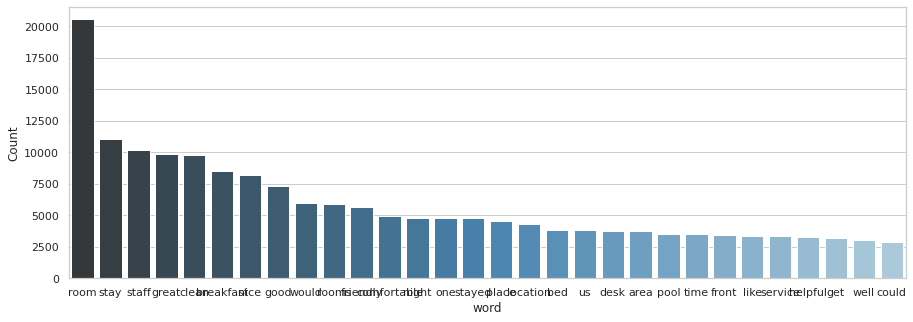

In [0]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})


  d = words_df.nlargest(columns="count", n = terms) 
  print(d[0:20])
  plt.figure(figsize=(15,5))
  
  ax = sns.barplot(data=d, x= "word", y = "count",palette="Blues_d")
  ax.set(ylabel = 'Count')
  plt.show()
  
freq_words(ct) 


In [0]:
!python -m spacy download en

In [0]:
#streamline function restore words to original 
nlp = spacy.load('en', disable=['parser', 'ner'])
def lemm(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
  output = []
  for sent in texts:
    doc = nlp(" ".join(sent)) 
    output.append([token.lemma_ for token in doc if token.pos_ in tags])
  return output

In [0]:
tokenized_reviews = pd.Series(ct).apply(lambda x: x.split())
r_2 = lemm(tokenized_reviews)

            word  count
10          room  25017
16         staff   9614
19         great   8594
8           good   8154
52         clean   8046
7      breakfast   7666
65          nice   6907
28         night   5856
37           bed   5275
17      friendly   5099
6    comfortable   4859
261        place   4781
81          time   4362
201         area   3892
262         desk   3553
20      location   3481
359         pool   3113
246      service   3031
18       helpful   3029
97           day   2985


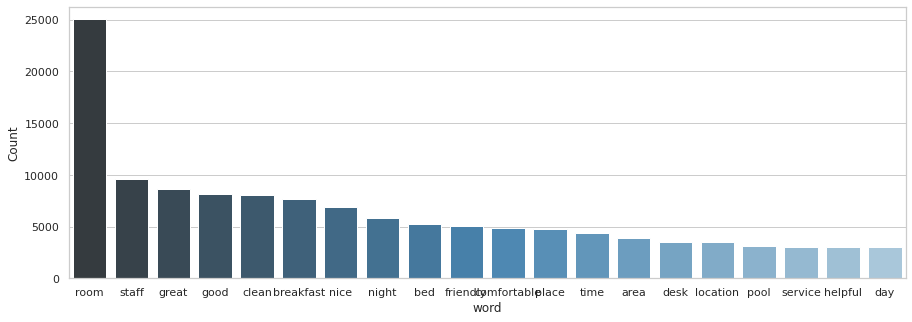

In [0]:
# reduce the noise it looks better now
r_3 = []
for i in range(len(r_2)):
  r_3.append(' '.join(r_2[i]))
  
freq_words(r_3, 20)

In [0]:
dictionary = gensim.corpora.Dictionary(reviews_2)
doc_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]
#LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel
lda_model = LDA(corpus=doc_matrix,id2word=dictionary,num_topics=6, random_state=100,chunksize=1000,passes=50)

In [0]:
lda_model.print_topics() 
# Visualize
pyLDAvis.enable_notebook()
plot = pyLDAvis.gensim.prepare(lda_model, doc_matrix, dictionary)
plot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.146809 -0.094907       1        1  29.846397
2     -0.013415  0.073884       2        1  18.457592
0     -0.096126  0.244088       3        1  15.717088
3     -0.123849  0.062371       4        1  15.591012
1     -0.020725 -0.314678       5        1  14.403664
5      0.400924  0.029243       6        1   5.984253, topic_info=          Term          Freq         Total Category  logprob  loglift
16       great   8508.000000   8508.000000  Default  30.0000  30.0000
9         room  23961.000000  23961.000000  Default  29.0000  29.0000
1    breakfast   7487.000000   7487.000000  Default  28.0000  28.0000
42       clean   7897.000000   7897.000000  Default  27.0000  27.0000
15    friendly   4710.000000   4710.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
649        kid    197.420258    824.892090   Topic6  -4.9487   1.3861
329       free    240.618881   2228.155762   Topic6  -4.7508   0.5903
536       rate    187.424454    686.745850   Topic6  -5.0006   1.5175
245    service    207.110992   2708.728271   Topic6  -4.9007   0.2451
9         room    178.718201  23961.669922   Topic6  -5.0482  -2.0824

[358 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
84        1  0.121516    able
84        2  0.775726    able
84        3  0.101735    able
310       5  0.798089  access
310       6  0.201511  access
...     ...       ...     ...
13        3  0.640594    work
264       1  0.247641    year
264       2  0.587765    year
264       5  0.081018    year
264       6  0.083311    year

[469 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 1, 4, 2, 6])

In [0]:
#save model for later use
lda_model.save('/content/drive/My Drive/NLP/Project/topic.model')
dictionary.save('/content/drive/My Drive/NLP/Project/dictionary.dict')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
loa_m = lda_model.load('/content/drive/My Drive/NLP/Project/topic.model')
data[]

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


# Use the LDA model to predict the category

In [0]:
def pre_new(doc):
  x=sk.clean_text(doc)
  str_convert = ''.join(x)
  x = str_convert.split()
  y = dictionary.doc2bow(x)
  return y

In [0]:
loa_m[(pre_new('the staff is not helpful at all '))]

[(0, 0.055555556),
 (1, 0.055623654),
 (2, 0.055616856),
 (3, 0.055555556),
 (4, 0.7220928),
 (5, 0.055555556)]

In [0]:
loa_m[(pre_new('the location is close to the town'))]

[(0, 0.04168282),
 (1, 0.7914655),
 (2, 0.041666668),
 (3, 0.041666668),
 (4, 0.041851655),
 (5, 0.04166667)]

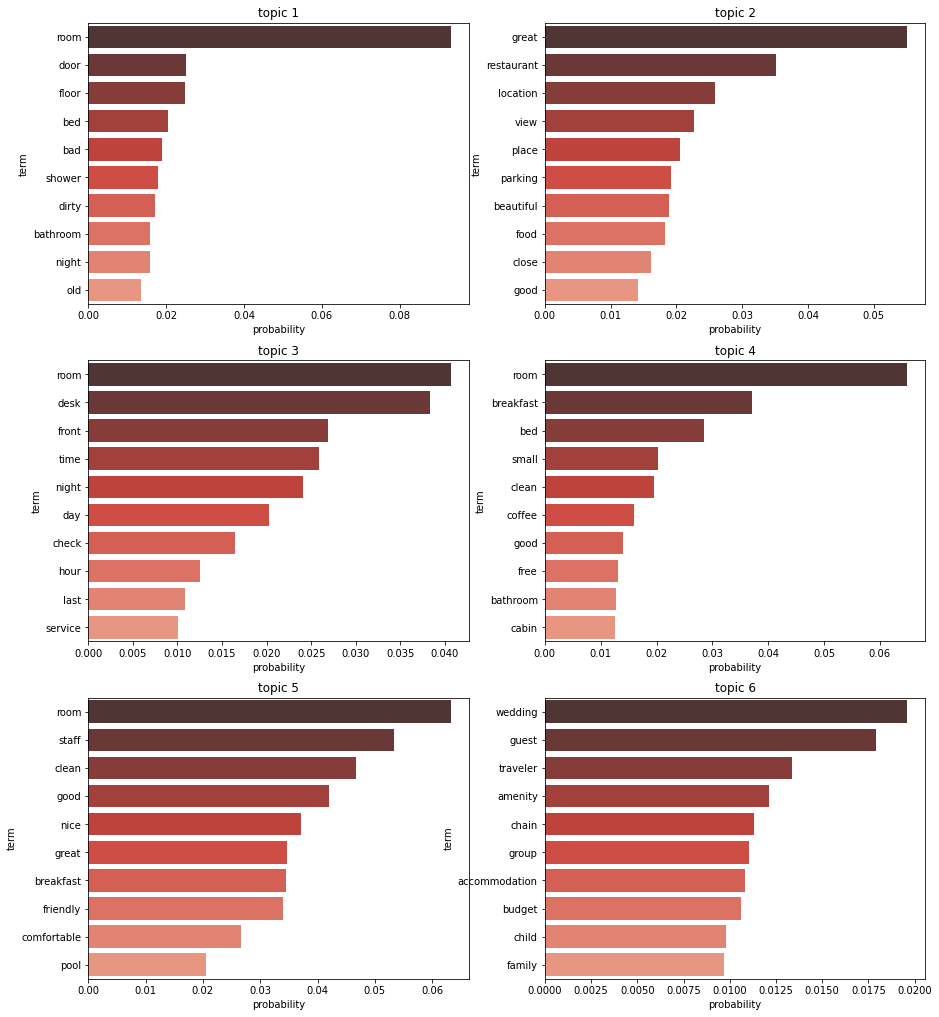

In [0]:
fiz=plt.figure(figsize=(15,30))
for i in range(6):
    df=pd.DataFrame(loa_m.show_topic(i), columns=['term','prob']).set_index('term')
#     df=df.sort_values('prob')
    
    plt.subplot(5,2,i+1)
    plt.title('topic '+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df, label='Cities', palette='Reds_d')
    plt.xlabel('probability')
    

plt.show()

#cross-check the “Machine learning algorithms to predict hotel ratings”
---

To see wheather the hotel predict algorithm can predict a suitable hotel  
or not, by chack the recommend hotel's key word and the keyword in the input sentence  

In [0]:
import functools
import operator
x=data.loc[data['name'] == 'Hampton Inn Virginia Beach Oceanfront North']
sk=sk_TF()
tf_list=[]

for i in x['reviews.text']:
  if len(i.split())>2:
    #sk=sk_TF()
    t=sk.clean_text(i)
    #print(t)
    x=sk.get_topic(t)
    #print(x)
    tf_list.append(x)
  else:
    tf_list.append(" ")
List_flat = functools.reduce(operator.iconcat, tf_list, [])
tags = set([ 'JJ',"NN"])
key=[]

for i in (tf_list):

  pos_tags =nltk.pos_tag(i)
  #print(pos_tags)
  ret=[]
  for word,pos in pos_tags:
    if (pos in tags):
      ret.append(word)
  key.append(ret)

List_flat = functools.reduce(operator.iconcat, key, [])
import collections
count=collections.Counter(List_flat)
print(count)
#print(set(List_flat))

Counter({'great': 76, 'breakfast': 75, 'room': 71, 'staff': 64, 'clean': 46, 'stay': 46, 'location': 42, 'beach': 33, 'nice': 31, 'good': 27, 'view': 25, 'time': 23, 'hotel': 19, 'ocean': 19, 'pool': 19, 'hampton': 18, 'free': 18, 'restaurant': 16, 'helpful': 16, 'friendly': 16, 'food': 14, 'balcony': 14, 'wonderful': 13, 'family': 12, 'area': 12, 'desk': 11, 'bar': 11, 'right': 11, 'inn': 10, 'front': 10, 'comfortable': 10, 'perfect': 10, 'linda': 9, 'awesome': 9, 'bad': 9, 'hot': 9, 'everyone': 9, 'many': 8, 'check': 8, 'everything': 8, 'place': 8, 'next': 8, 'experience': 8, 'morning': 8, 'excellent': 8, 'floor': 7, 'happy': 7, 'able': 7, 'trip': 7, 'convenient': 7, 'boardwalk': 7, 'close': 7, 'va': 6, 'complimentary': 6, 'little': 6, 'year': 6, 'thing': 6, 'dirty': 6, 'price': 6, 'day': 6, 'second': 6, 'quiet': 6, 'way': 6, 'beautiful': 6, 'service': 6, 'last': 6, 'bathroom': 5, 'kind': 5, 'future': 5, 'lot': 5, 'weekend': 5, 'overall': 5, 'holiday': 5, 'plenty': 5, 'fantastic': 5,

In [0]:
x=data.loc[data['name'] == 'La Quinta Inn Auburn Worcester']
x
sk=sk_TF()
tf_list=[]

for i in x['reviews.text']:
  if len(i.split())>2:
    #sk=sk_TF()
    t=sk.clean_text(i)
    #print(t)
    x=sk.get_topic(t)
    #print(x)
    tf_list.append(x)
  else:
    tf_list.append(" ")
List_flat = functools.reduce(operator.iconcat, tf_list, [])
tags = set([ 'JJ',"NN"])
key=[]

for i in (tf_list):

  pos_tags =nltk.pos_tag(i)
  #print(pos_tags)
  ret=[]
  for word,pos in pos_tags:
    if (pos in tags):
      ret.append(word)
  key.append(ret)

List_flat = functools.reduce(operator.iconcat, key, [])
import collections
count=collections.Counter(List_flat)
print(count)
#print(set(List_flat))


Counter({'room': 44, 'clean': 35, 'breakfast': 23, 'staff': 22, 'good': 17, 'stay': 16, 'comfortable': 15, 'nice': 9, 'area': 9, 'night': 9, 'friendly': 9, 'smoke': 9, 'front': 8, 'great': 8, 'place': 7, 'time': 7, 'pet': 6, 'hotel': 6, 'free': 6, 'price': 6, 'easy': 6, 'desk': 6, 'bathroom': 5, 'bed': 5, 'quiet': 5, 'location': 5, 'helpful': 5, 'smell': 5, 'smoking': 5, 'way': 5, 'dog': 5, 'horrible': 4, 'pleasant': 4, 'perfect': 4, 'convenient': 4, 'service': 4, 'non': 4, 'la': 4, 'quinta': 4, 'major': 3, 'basic': 3, 'rate': 3, 'day': 3, 'hard': 3, 'bit': 3, 'quick': 3, 'much': 3, 'air': 3, 'issue': 3, 'fine': 3, 'decent': 3, 'motel': 3, 'refrigerator': 3, 'highway': 3, 'water': 3, 'fresh': 3, 'big': 3, 'stale': 3, 'close': 3, 'wifi': 3, 'low': 3, 'overall': 3, 'many': 3, 'full': 3, 'need': 2, 'lot': 2, 'order': 2, 'noise': 2, 'yogurt': 2, 'cereal': 2, 'musty': 2, 'rock': 2, 'pillow': 2, 'checkout': 2, 'shaweet': 2, 'difficult': 2, 'check': 2, 'morning': 2, 'elevator': 2, 'sink': 2, 

In [0]:
x=data.loc[data['name'] == 'Comfort Suites Southport']
x
sk=sk_TF()
tf_list=[]

for i in x['reviews.text']:
  if len(i.split())>2:
    #sk=sk_TF()
    t=sk.clean_text(i)
    #print(t)
    x=sk.get_topic(t)
    #print(x)
    tf_list.append(x)
  else:
    tf_list.append(" ")
List_flat = functools.reduce(operator.iconcat, tf_list, [])
tags = set([ 'JJ',"NN"])
key=[]

for i in (tf_list):

  pos_tags =nltk.pos_tag(i)
  #print(pos_tags)
  ret=[]
  for word,pos in pos_tags:
    if (pos in tags):
      ret.append(word)
  key.append(ret)

List_flat = functools.reduce(operator.iconcat, key, [])
import collections
count=collections.Counter(List_flat)
print(count)

Counter({'room': 22, 'staff': 12, 'breakfast': 11, 'clean': 7, 'comfortable': 6, 'great': 6, 'good': 6, 'time': 5, 'town': 5, 'friendly': 5, 'hotel': 5, 'front': 4, 'stay': 4, 'location': 4, 'island': 4, 'nice': 4, 'helpful': 4, 'little': 4, 'place': 3, 'desk': 3, 'convenient': 3, 'get': 3, 'someone': 2, 'ready': 2, 'key': 2, 'problem': 2, 'machine': 2, 'drive': 2, 'road': 2, 'parking': 2, 'lot': 2, 'furniture': 2, 'beach': 2, 'wife': 2, 'wedding': 2, 'lady': 2, 'oak': 2, 'construction': 2, 'anyone': 2, 'wonderful': 2, 'day': 2, 'space': 2, 'large': 2, 'southport': 2, 'way': 2, 'traffic': 2, 'area': 2, 'mold': 2, 'overall': 2, 'offer': 1, 'inconvenience': 1, 'didnt': 1, 'shampoo': 1, 'ran': 1, 'maker': 1, 'door': 1, 'size': 1, 'couch': 1, 'side': 1, 'wait': 1, 'short': 1, 'cute': 1, 'note': 1, 'pet': 1, 'sneak': 1, 'queen': 1, 'sofa': 1, 'sleeper': 1, 'checkin': 1, 'chair': 1, 'star': 1, 'old': 1, 'ok': 1, 'alot': 1, 'pool': 1, 'close': 1, 'mi': 1, 'year': 1, 'return': 1, 'sure': 1, 'e